[*********************100%***********************]  1 of 1 completed


C:\Users\mehdi\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\mehdi\AppData\Local\Temp\ipykernel_13652\2730759266.py:64: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  indicator = pd.Series(index=etf_oil_log_ratio.index)


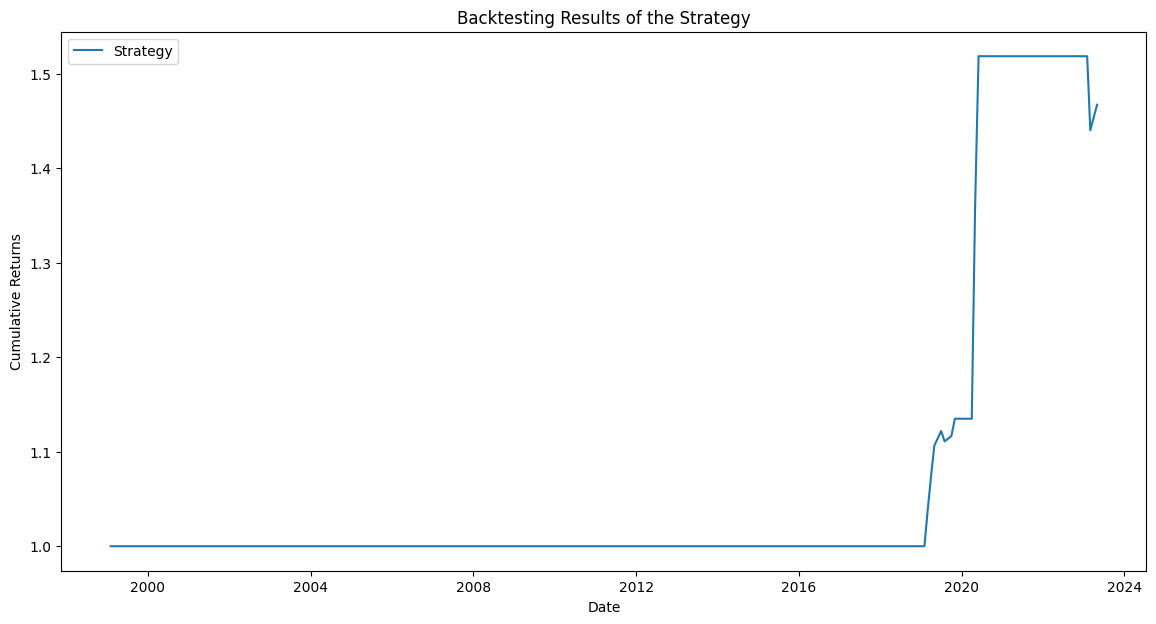

In [1]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
from fredapi import Fred
from pandas.tseries.offsets import DateOffset
from sklearn.linear_model import LinearRegression


def convert_date_to_ordinal(date):
    return date.toordinal()


def calculate_slope(X, y):
    """Fit a linear regression model and return the slope"""
    model = LinearRegression()
    model.fit(X, y)
    return model.coef_[0]


# Fetch XLY ETF data
etfs_data = yf.download('XLY')
etf_close = pd.DataFrame(etfs_data["Close"])
etf_close.rename(columns={"Close": "XLY"}, inplace=True)

# Calculate 200-day moving average for XLY
etf_close['XLY_200_SMA'] = etf_close['XLY'].rolling(window=200).mean()

# Replace 'your_api_key' with your actual FRED API key
fred = Fred(api_key='2f15c96b46530fde1b1992a64c64650e')

# Fetch Consumer Price Index for All Urban Consumers: All Items in U.S. City Average (CPIAUCSL)
cpi_data = fred.get_series('CPIAUCSL')
# Convert the series into a DataFrame
cpi_df = pd.DataFrame(cpi_data, columns=['CPI'])
# Compute the natural logarithm of the CPI
cpi_df['log_CPI'] = np.log(cpi_df['CPI'])
# Merge datasets
combined_df = etf_close.join(cpi_df, how='inner').fillna(method='ffill')

# Compute the inflation indicator for each data point
for i in range(12*7, len(combined_df)):
    X = combined_df.index[:i].map(pd.Timestamp.toordinal).values.reshape(-1, 1)
    y = combined_df['log_CPI'].iloc[:i].values
    
    model_1 = LinearRegression()
    model_1.fit(X[-12:], y[-12:])
    
    model_7 = LinearRegression()
    model_7.fit(X[-12*7:], y[-12*7:])
    
    y_pred_1 = model_1.predict([X[-1]])
    y_pred_7 = model_7.predict([X[-1]])
    
    combined_df.loc[combined_df.index[i], 'inflation_indicator'] = 0 if y_pred_7 < y_pred_1 else 1

# Compute the growth indicator
oil_price = fred.get_series('DCOILWTICO')
oil_price = oil_price.dropna()
etf_close = etf_close.reindex(oil_price.index).dropna()
etf_log = np.log(etf_close['XLY'])
oil_log = np.log(oil_price)
etf_oil_log_ratio = etf_log.div(oil_log)
indicator = pd.Series(index=etf_oil_log_ratio.index)

for date in etf_oil_log_ratio.index:
    one_year_ago = date - DateOffset(years=1)
    last_year_log_ratio = etf_oil_log_ratio[(etf_oil_log_ratio.index >= one_year_ago) & (etf_oil_log_ratio.index < date)]
    if not last_year_log_ratio.empty:
        X1 = np.array(last_year_log_ratio.index.map(convert_date_to_ordinal)).reshape(-1, 1)
        y1 = last_year_log_ratio.values
        valid_indices = ~np.isnan(y1)
        X1 = X1[valid_indices]
        y1 = y1[valid_indices]
        if len(y1) > 0:
            one_year_slope = calculate_slope(X1, y1)
            seven_years_ago = date - DateOffset(years=7)
            last_seven_years_log_ratio = etf_oil_log_ratio[(etf_oil_log_ratio.index >= seven_years_ago) & (etf_oil_log_ratio.index < date)]
            if not last_seven_years_log_ratio.empty:
                X7 = np.array(last_seven_years_log_ratio.index.map(convert_date_to_ordinal)).reshape(-1, 1)
                y7 = last_seven_years_log_ratio.values
                valid_indices = ~np.isnan(y7)
                X7 = X7[valid_indices]
                y7 = y7[valid_indices]
                if len(y7) > 0:
                    seven_years_slope = calculate_slope(X7, y7)
                    indicator[date] = int(one_year_slope > seven_years_slope)

combined_df['growth_indicator'] = indicator

# Calculate the daily returns of the strategy
combined_df['strategy_daily_returns'] = 0
combined_df.loc[(combined_df['inflation_indicator'].shift(1) == 0) & (combined_df['growth_indicator'].shift(1) == 1), 'strategy_daily_returns'] = combined_df['XLY'].pct_change()

# Calculate the cumulative returns of the strategy
combined_df['strategy_cumulative_returns'] = (1 + combined_df['strategy_daily_returns']).cumprod()

# Plot the cumulative returns of the strategy
plt.figure(figsize=(14, 7))
plt.plot(combined_df['strategy_cumulative_returns'], label='Strategy')
plt.title('Backtesting Results of the Strategy')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.show()